In [1]:
%matplotlib inline

In [2]:
import torch
import torch.nn as nn

In [3]:
from pdb import set_trace

In [4]:
class LabelSmoothingLoss(nn.Module):
    
    def __init__(self, dim=-1):
        super().__init__()
        self.dim = dim

    def forward(self, one_hot_target, preds):
        preds = preds.log_softmax(dim=self.dim)
        return torch.mean(torch.sum(-one_hot_target * preds, dim=self.dim))

In [5]:
from catalyst.utils import get_one_hot

In [6]:
y_true = torch.tensor([1, 1, 0, 2, 1])

y_pred_1 = torch.tensor([
    [0.19, 0.8, 0.01],
    [0.82, 0.08, 0.1],
    [0.9, 0.05, 0.05],
    [0.2, 0.2, 0.6],
    [0.9, 0.07, 0.03]
])

y_pred_2 = torch.tensor([
    [0.00, 1.00, 0.00],
    [0.00, 1.00, 0.00],
    [1.00, 0.00, 0.00],
    [0.00, 0.00, 1.00],
    [0.00, 1.00, 0.00]
])

y_true_onehot = torch.tensor([get_one_hot(x, 3, 0.1) for x in y_true])

loss_fn = LabelSmoothingLoss(3)
print(loss_fn(y_pred_1, y_true))
print(loss_fn(y_pred_2, y_true))

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 3)

In [7]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, _LRScheduler
import numpy as np

In [8]:
class CosineDecay(_LRScheduler):
    def __init__(self, optimizer, total_steps, 
                 linear_frac=0.1, min_lr=1e-6,
                 last_epoch=-1):
        
        self.optimizer = optimizer
        self.total_steps = total_steps
        self.linear_frac = linear_frac
        self.min_lr = min_lr
        self.linear_steps = total_steps * linear_frac
        self.cosine_steps = total_steps - self.linear_steps
        super().__init__(optimizer, last_epoch)
        
    def get_lr(self):
        step = self.last_epoch
        if step <= self.linear_steps:
            return [(step/self.linear_steps) * base_lr for base_lr in self.base_lrs]
        else:
            t = self.last_epoch - self.linear_steps
            T = self.cosine_steps
            return [self.min_lr + (base_lr - self.min_lr)*(1 + np.cos(t*np.pi/T))/2
                    for base_lr in self.base_lrs]

In [9]:
import torch.nn.functional as F

In [10]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(3, 32, 3)
        self.c2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, 10)
    def forward(self, x):
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = self.pool(x).squeeze()
        x = self.fc(x)
        return x

In [11]:
input_tensor = torch.ones((16, 3, 32, 32))
m = Model()
max_lr = 1e-3
opt = torch.optim.AdamW(params=[
    {'params': m.c1.parameters(), 'lr': 1e-3},
    {'params': m.c2.parameters(), 'lr': 1e-2},
    {'params': m.fc.parameters(), 'lr': 1e-1}
])
sched = CosineDecay(opt, 120, linear_frac=0.1)
lrs = []
for i in range(120):
    sched.step()
    lrs.append(sched.get_lr())
lrs = np.array(lrs)

/home/ck/anaconda3/envs/fastai_10/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:82: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate



In [12]:
import matplotlib.pyplot as plt

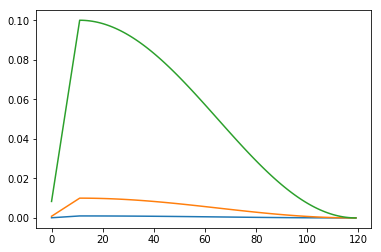

In [13]:
plt.plot(lrs[:, 0])
plt.plot(lrs[:, 1])
plt.plot(lrs[:, 2])

In [14]:
from apex import amp
opt_level = 'O1'
m = m.to('cuda:0')
m, opt = amp.initialize(m, opt, opt_level=opt_level, num_losses=1)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
